# Practica 1 - Preprocesamiento de datos y evaluación de modelos de clasificación/regresión.

**Nombres:** Alejandro Moya Moya y Jorge Valero Molina                 
**Año:** 2017/18
**Revisión:** 1.0

## Antes de empezar...

In [1]:
# Cargamos las librerias necesarias para poder realizar la práctica.

import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)

import base64

from sklearn import tree

# Este codigo configura matplotlib para una representacion adecuada
%matplotlib inline
mpl.rcParams["figure.figsize"] = "8, 4"
import warnings
warnings.simplefilter("ignore")

# Establecemos una semilla para poder obtener siempre los resultados
import random
seed=1234
np.random.seed(seed)


######## Holdout ########

# Holdout no estratificado (No se usa en la practica, solo de pruebas)
def holdout (trainingSize, dataset):
    # Calcula el tamano de la particion
    from math import ceil
    cutIndex = ceil(len(dataset) * trainingSize)
    
    # Aleatorizacion del conjunto de datos mediante el uso de permutacion aleatoria de su indice
    randomIndex = np.random.permutation( dataset.index )
    datasetpermdf = dataset.reindex( randomIndex )
    

    # Division del conjunto de datos en dos subconjuntos por indice:
    # Devuelve un par (ConjuntoEntrenamiento, ConjuntoTest)
    return (datasetpermdf.iloc[0:cutIndex-1], datasetpermdf.iloc[cutIndex:])

# Holdout estratificado
def holdout_estratificado (trainingSize, dataset, seed):
    attributesdf = dataset.drop('label', 1)
    labeldf = dataset['label']
    from sklearn.model_selection import train_test_split
    train_atts, test_atts, train_label, test_label = train_test_split( 
        attributesdf, # Dataset con los atributos
        labeldf, # Vector/dataset con la clase
        test_size= 1 - trainingSize, # Proporcion de test
        random_state=seed, # Semilla
        stratify=labeldf) # Variable a estratificar
    # Devuelve un par (ConjuntoEntrenamiento, ConjuntoTest)
    return (train_atts.assign(label = train_label) , test_atts.assign(label = test_label))


######## Clasificadores ########

# Clasificador ZeroR
def trainZeroR(trainingData):
    # Aprendemos los parametros, es decir, la clase mas probable
    majorClass = trainingData.label.mode()[0] # <-- COMPLETE
    
    # Creamos y devolvemos la funcion del clasificador
    def classifier( data ):
        return data.assign( prediction = majorClass )
    
    return classifier


# Clasificador OneR
def trainOneR(trainingData, nbins = 1, debug = True):
    # Debug: 
    if debug:
        print("-----------------------------------")
        print("Training OneR")
        print("-----------------------------------")
        print("attribute\terror")
    # ------------------------------------

    # Maximizacion de las variables
    best_attribute = ''
    best_partitions = []
    best_classes = []
    best_error =  float("inf")
    
    # Cogemos cada atributo y calculamos su error
    for att in trainingData.columns.values: 
        # Ignoramos la variable clase
        if att == 'label': continue

        # Generamos las particiones
        (attribute, bins) = pd.cut(trainingData[att], bins = nbins, retbins=True)

        # Computamos el error
        tab = pd.crosstab(attribute, trainingData['label'])
        error = sum( [ sum(f) - max(f) for f in tab.values ] )

        # Con esto mostramos el error de cada una de las variables - DEBUG
        if debug:
            print(att, "\t", error)
        # ----------------------------------------
        
        # Comparamos el error calculado con el error optimo obtenido anteriormente
        if (error < best_error):
            # If that is the case we store it as the current local optima
            best_attribute  = att
            best_partitions = bins[1:]
            # Almacenamos la clase mayoritaria para cada  para asignarlo durante la clasificacion
            best_classes = [ tab.columns[f.argmax()] for f in tab.values ]
            best_error = error
            

    # Creamos y devolvemos la funcion del clasificador
    def classifier( testData ):
        # Se asigna la clase mayoritaria para cada intervalo
        # Verificamos a que intervalo pertenece el valor actual para el atributo optimo y asignar
        # la clase mayoritaria almacenada
        def assignClass( attValue ):
            for i in range(nbins):
                if attValue <= best_partitions[i]:
                    return best_classes[i]

        # Aplicamos la funcion anterior a todas las instancias en el conjunto de datos
        prediction = list(map( assignClass, testData[best_attribute] ))

        return testData.assign( prediction = prediction )
    
    print("-----------------------------------")
    return classifier

# Funcion que agiliza la llamada a las funciones OneR y ZeroR.
# Devuelve un par con la matriz de confusion y con el accuracy de aplicar el modelo obtenido al conjunto Test
def trainAndEvalClassifier(classifier, trainingDf, testDf, **kwargs):
    model = classifier(trainingDf, **kwargs)
    predictedDf = model(testDf)
    tab = pd.crosstab(predictedDf['label'], predictedDf['prediction'])
    comparison = predictedDf[predictedDf['label'] == predictedDf['prediction'] ]
    accuracy = len(comparison) / len(predictedDf)
    return (tab, accuracy)

# Arbol de decision
# Devuelve un par (accuracy, matrizConfusion)
def arbolDecision(trainingDf, testDf):
    # Inicio del modelo
    model = tree.DecisionTreeClassifier(random_state=seed)
    features = trainingDf.drop('label',1)
    labels = trainingDf['label']
    
    # Use "fit" para aprender de un modelo configurado
    classifier = model.fit(features, labels)
    
    testFeatures = testDf.drop('label',1)
    prediction = classifier.predict(testFeatures)
    
    comparison = testDf[testDf['label'] == prediction]
    accuracy = len(comparison) / len(testDf)
    return (accuracy, prediction)

# Esta funcion nos devuelve la fraccion de casos positivos se han detectado
def recall(TP,FN):
    return(TP/(TP+FN))

######## Funciones de las gráficas ########

# Histograma-densidad de todas las variables de un dataset
def gMultipleHistogram(targetdf):
    # Se elimina la variable clase
    target_noclass = targetdf.drop('label', 1)
    # Se generan los multiples histogramas
    g = sns.FacetGrid(pd.melt(target_noclass), col="variable", sharey=False, sharex=False, col_wrap=2)
    g.map(sns.distplot, "value");   

# Diagrama de barras para una variable
def gSingleBarplot(targetDf, targetVar):
    sns.countplot(data=targetDf, x=targetVar)

# Histograma condicionada por la clase para una variable dada
def gSingleConditionalHistogram(targetdf, att):
    sns.pairplot(targetdf[[att, 'label']], hue="label", size=5)

# Diagrama de cajas de una variable dada con respecto a la variable clase
def gSingleBoxplot(targetdf, att):
    sns.boxplot(x='label', y=att, data=targetdf)

# Separabilidad de la clase entre atributos predictores
# Función no utilizada (solo como test)
def gPairPlot(targetDf):
    sns.pairplot(targetDf, hue="label");

# Pima_Diabetes
A continuación, vamos a proceder a analizar el conjunto de datos de Pima_Diabetes

In [2]:
# Cargamos el fichero con el conjunto de datos. OJO: colocar el fichero de datos en el mismo directorio que esta libreta

df_pima = pd.read_csv("pima.csv", dtype={ "label": 'category'})

In [3]:
# Vamos a conocer un poquito el dataset, para ello veamos el nº de instancias y el nº de variables a tratar

aux = df_pima.shape
print("Nº de instancias: " + str(aux[0]))
print("Nº de variables a tratar: " + str(aux[1]-1))

df_pima.describe()

Nº de instancias: 768
Nº de variables a tratar: 8


,preg,plas,pres,skin,insu,mass,pedi,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


## Visualización de las variables
Para ir analizando todos los datos del dataset vamos a realizar una serie de histogramas, diagramas de cajas (para las variables numéricas) y un diagrama de barras (para la variable clase discreta).

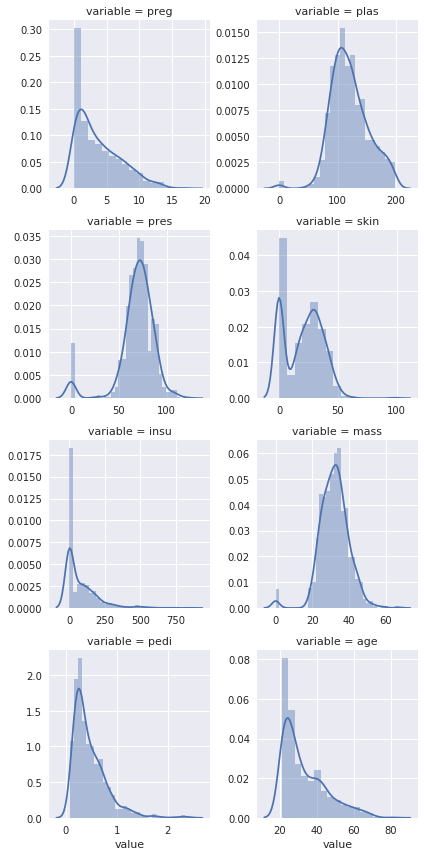

In [4]:
 gMultipleHistogram(df_pima)

Variable plas, con plas == 0: 5
Variable mass, con mass == 0: 11
Variable pres, con pres == 0: 35


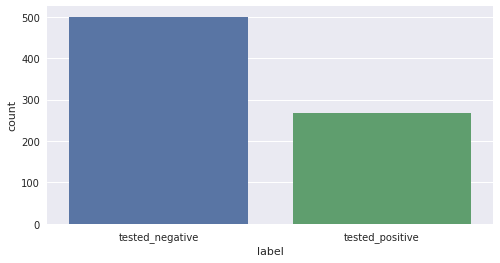

In [5]:
gSingleBarplot(df_pima, "label")
print ("Variable plas, con plas == 0: " + str(df_pima[df_pima["plas"] == 0].shape[0]))
print ("Variable mass, con mass == 0: " + str(df_pima[df_pima["mass"] == 0].shape[0]))
print ("Variable pres, con pres == 0: " + str(df_pima[df_pima["pres"] == 0].shape[0]))

Información de los atributos:

1. 'preg':  Número de veces embarazadas 
2. 'plas':  Concentración de glucosa en plasma a las 2 horas en una prueba oral de tolerancia a la glucosa 
3. 'pres':  Presión arterial diastólica (mm Hg) 
4. 'skin':  Grosor del pliegue de la piel del tríceps (mm) 
5. 'insu':  Insulina sérica de 2 horas (mu U / ml) 
6. 'mass':  Índice de masa corporal (peso en kg / (altura en m) ^ 2) 
7. 'pedi':  Función pedigrí de la diabetes 
8. 'age':   Edad (años) 
9. 'label': Variable de clase (0 o 1) 

Con la variable 'preg' podríamos llegar a pensar que el nº de embarazos mayores que 10 podría ser datos erroneos (atípicos), pero dado que desconocemos el origen de los datos no podemos darlos por malos, ya que podría ser normal en ciertas culturas. En cuanto a los valores '0' de las variables 'plas', 'pres', 'skin', 'insu', 'mass' y 'pedi' no podemos determinar si pueden ser erroneos o no, puesto que desconocemos de la materia, en este caso, preguntaríamos a un experto. Más adelante, trataremos estos casos sustituyendolos (NaN y media de la variable) por diferentes valores y analizaremos si mejoramos o no la clasificación. Estos datos a continuación lo vamos a interpretar como datos válidos.

Con los histogramas obtenidos, no somos capaces de determinar cuales son las variables con mayor relevancia, para ello, analizaremos los diagramas de cajas de cada una de ellas con respecto a la variable clase.


Por último, nos queda comentar que la muestra no está balanceada debido a que las frecuencias de las distintas combinaciones de estados de las mismas no aparecen en la misma proporción. 500 instancias de test negativos con respecto a 268 de tests positivos.

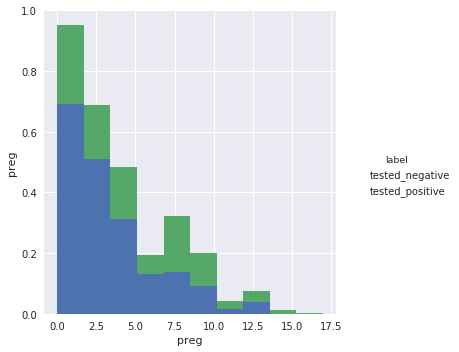

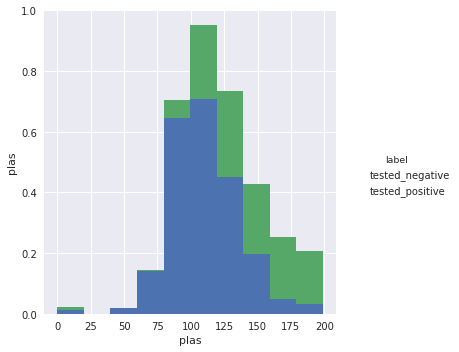

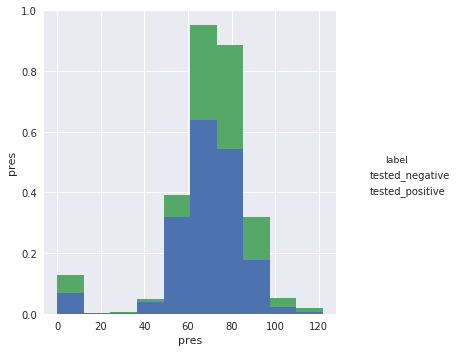

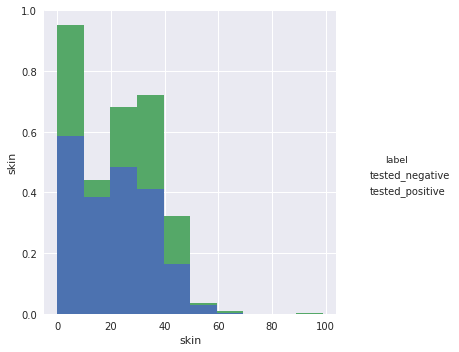

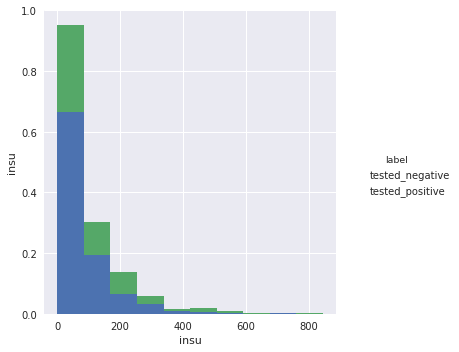

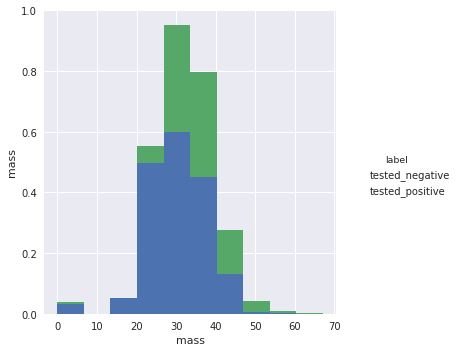

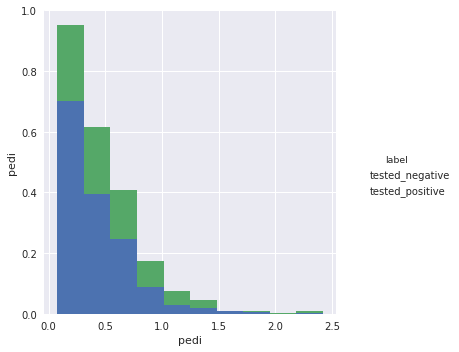

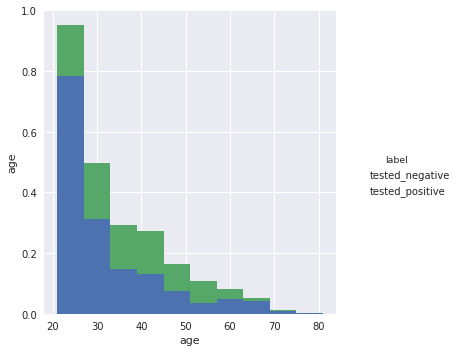

In [6]:
gSingleConditionalHistogram(df_pima, "preg")
gSingleConditionalHistogram(df_pima, "plas")
gSingleConditionalHistogram(df_pima, "pres")
gSingleConditionalHistogram(df_pima, "skin")
gSingleConditionalHistogram(df_pima, "insu")
gSingleConditionalHistogram(df_pima, "mass")
gSingleConditionalHistogram(df_pima, "pedi")
gSingleConditionalHistogram(df_pima, "age")

Los histogramas condicionales con respecto a la variable clase no nos aporta nada de información. Por ello, vamos a analizar los diagramas de cajas.

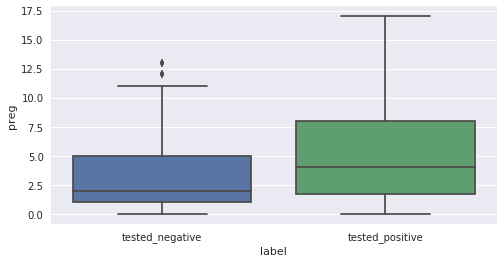

In [7]:
gSingleBoxplot(df_pima, "preg")

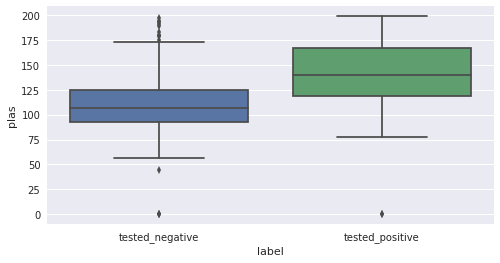

In [8]:
gSingleBoxplot(df_pima, "plas")

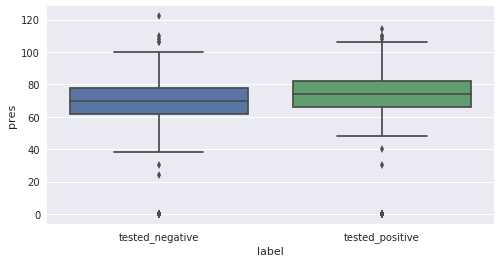

In [9]:
gSingleBoxplot(df_pima, "pres")

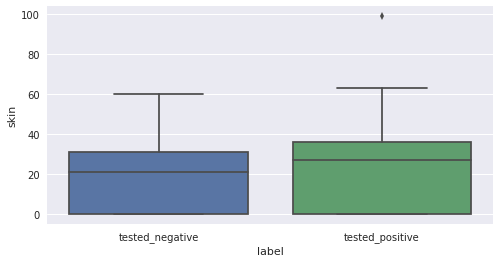

In [10]:
gSingleBoxplot(df_pima, "skin")

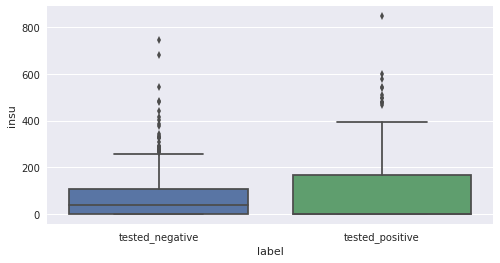

In [11]:
gSingleBoxplot(df_pima, "insu")

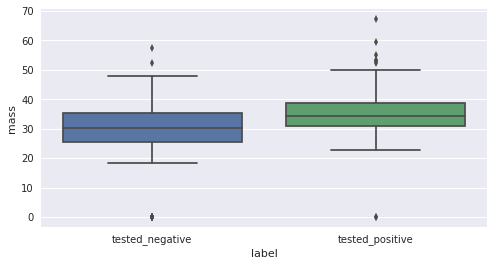

In [12]:
gSingleBoxplot(df_pima, "mass")

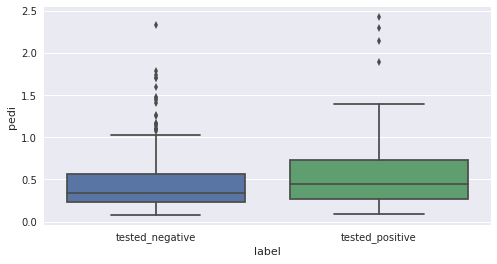

In [13]:
gSingleBoxplot(df_pima, "pedi")

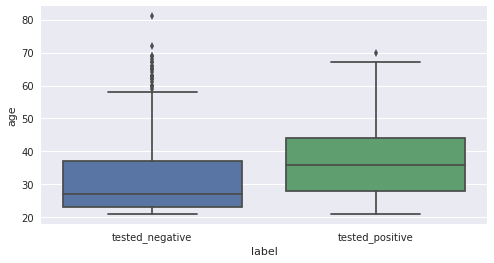

In [14]:
gSingleBoxplot(df_pima, "age")

Considerando los diagramas de cajas, podemos deducir que las variables más relevantes serán aquellas cuyas 'cajas' se superpongan menos, es decir, aquellas en las que los valores de la variable estén más diferenciadas dependiendo de la variable clase. Por lo tanto, concluimos que las variables 'plas' , 'preg', 'age' y 'mass' (mayor a menor relevancia). Las variables nombradas es una aproximación a "ojo", el clasificador OneR ya nos proporcionará cuales son las mejores y actuará en consecuencia.

In [15]:
#gPairPlot(df_pima) - Test (8*8 = 64 tablas!!!!)

## Aprendizaje y evaluación de un clasificador ZeroR


In [16]:
(TrainingPima,TestPima) = holdout_estratificado(0.6, df_pima, seed)
(tab, accuracy) = trainAndEvalClassifier(trainZeroR, TrainingPima, TestPima)
tab

prediction,tested_negative
label,
tested_negative,201
tested_positive,107


In [17]:
accuracy

0.6525974025974026

Como podemos apreciar, un ZeroR obtiene un mal accuracy puesto que clasificar todo como la variable mayoritaria es bastante ineficiente antes nuevos casos.
En este caso el ZeroR clasifica todos los casos como test_negative. Esto es muy malo para el sistema, ya que no podemos decir que todos los casos son negativos, ya que podrian ser diabeticos y producirse una desgracia en el futuro. Por lo tanto, se prefiere predecir que alguien es diabetico aunque no lo sea, mejor no arriesgarse.
Si calculasemos el recall, sería de 0, dado que clasificamos todos como tested_negative.

## Aprendizaje y evaluación de un clasificador OneR

In [18]:
(TrainingPima,TestPima) = holdout_estratificado(0.6, df_pima, seed)
(tab, accuracy) = trainAndEvalClassifier(trainOneR, TrainingPima, TestPima, nbins=len(df_pima.label.unique()))
tab

-----------------------------------
Training OneR
-----------------------------------
attribute	error
preg 	 150
plas 	 161
pres 	 161
skin 	 161
insu 	 159
mass 	 159
pedi 	 157
age 	 161
-----------------------------------


prediction,tested_negative,tested_positive
label,,
tested_negative,181,20
tested_positive,82,24


In [19]:
accuracy

0.6655844155844156

In [20]:
TP = tab['tested_positive']['tested_positive']
FN = tab['tested_negative']['tested_positive']

recall(TP,FN)

0.22641509433962265

Tras el procesamiento, OneR elige la variable 'preg' como la mejor variable para clasificar, debido a que tiene el menor error.
Podemos concluir que el accuracy obtenido es igual de malo que el ZeroR, además, el recall obtenido es bastante malo, ya que muchos pacientes con diabetes son diagnosticados como negativo y muy pocos con diabetes son diagnosticados como positivo.

## Aprendizaje y evaluación de un árbol de clasificación

In [21]:
(TrainingPima,TestPima) = holdout_estratificado(0.6, df_pima, seed)
(accuracy,prediction) = arbolDecision(TrainingPima,TestPima)
pd.crosstab(TestPima['label'], prediction)

col_0,tested_negative,tested_positive
label,,
tested_negative,157,44
tested_positive,49,58


In [22]:
accuracy

0.698051948051948

In [23]:
TP = pd.crosstab(TestPima['label'], prediction)['tested_positive']['tested_positive']
FN = pd.crosstab(TestPima['label'], prediction)['tested_negative']['tested_positive']

recall(TP,FN)

0.54205607476635509

Como podemos observar el accuracy no es tan malo como los anteriores, pero insuficiente. Esto es debido a "esos valores" que hemos supuesto que eran correctos (que seguimos desconociendo si son correctos o no), por lo tanto, vamos a realizar un preprocesamiento de los datos con el fin de tratar estos casos y ver si podemos obtener un clasificador mejor o peor. Para ello vamos a cambiar dichos valores por NaN (suponemos que ese "campo" debería estar vacio, es decir, los médicos no tomaron dichos datos) y por la medía de cada una de las variables (suponemos un fallo en la toma de los datos y por lo tanto para minimizar el error suponemos la media).

También debemos de comentar que el recall mejora bastante con respecto al anterior, aunque el recall sigue siendo ineficiente dado que más o menos la mitad de los casos están mal clasificados.

## Preprocesamiento de datos de df_pima (Sustitución de 0's por NaN)
Con todo lo analizado anteriormente, posiblemente si tratamos los datos que son erróneos o perdidos, podríamos llegar a conseguir unos mejores clasificadores, para ello, vamos a eliminar los 0s de las variables 'plas', 'pres', 'skin', 'insu' y 'mass' ya que nuestra lógica nos dice que estos valores nunca podrán ser 0, por ello vamos a sustituir estos valores por NaN, estos cambios deberían ser contrastados por un experto pero dado que carecemos de ello, vamos a suponerlo.
Haremos una copia de df_pima y trataremos los datos.

In [24]:
df_pimaCopy = df_pima.copy()
df_pimaCopy["plas"].replace(0, np.nan, inplace=True)
df_pimaCopy["pres"].replace(0, np.nan, inplace=True)
df_pimaCopy["skin"].replace(0, np.nan, inplace=True)
df_pimaCopy["insu"].replace(0, np.nan, inplace=True)
df_pimaCopy["mass"].replace(0, np.nan, inplace=True)
df_pimaCopy.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [25]:
#df_pimaCopy - Test: comprobacion de si se han remplazado los valores

Como podemos observar, al sustituir estos valores por NaN "perdemos" registros, y esto puede suponer un problema a la hora de calcular los clasificadores.

Dado que los histogramas no nos han aportado apenas información, vamos a realizar una serie de diagramas de cajas para cada una de las variables con respecto a la variable clase, para comprobar que variables son las más relevantes.

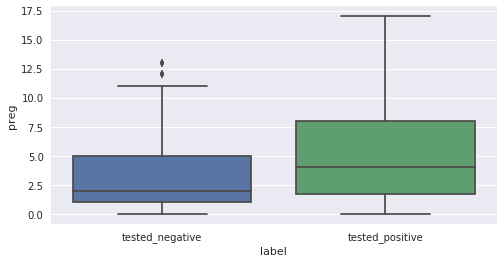

In [26]:
gSingleBoxplot(df_pimaCopy, "preg")

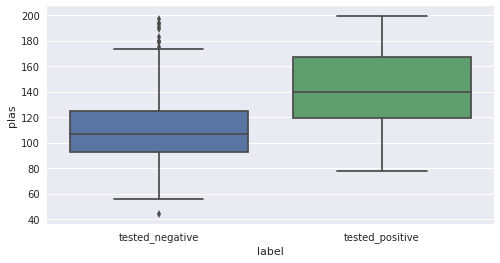

In [27]:
gSingleBoxplot(df_pimaCopy, "plas")

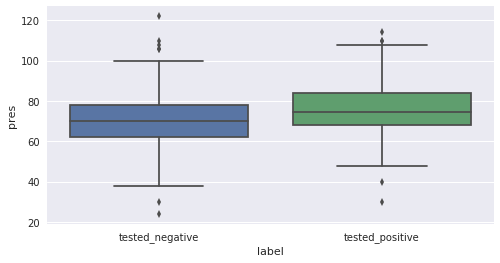

In [28]:
gSingleBoxplot(df_pimaCopy, "pres")

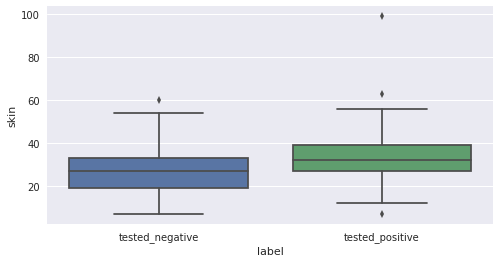

In [29]:
gSingleBoxplot(df_pimaCopy, "skin")

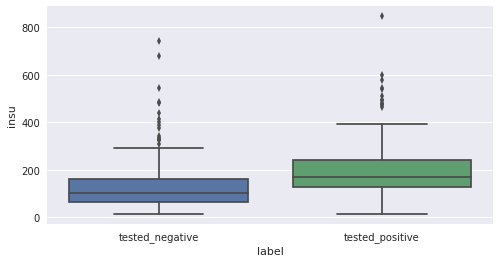

In [30]:
gSingleBoxplot(df_pimaCopy, "insu")

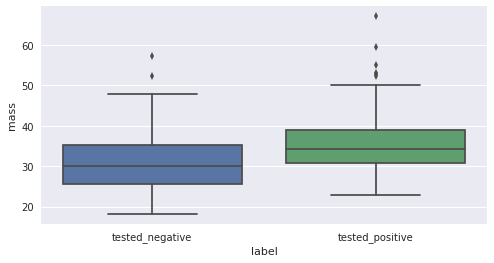

In [31]:
gSingleBoxplot(df_pimaCopy, "mass")

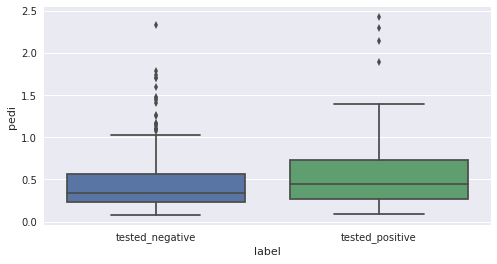

In [32]:
gSingleBoxplot(df_pimaCopy, "pedi")

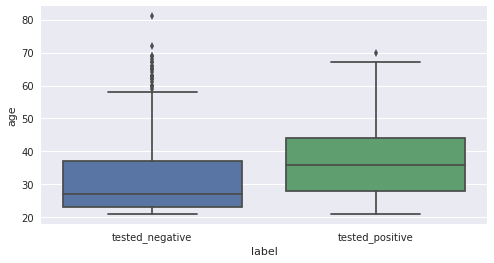

In [33]:
gSingleBoxplot(df_pimaCopy, "age")

Podemos observar que los diagramas de cajas han variado con respecto al principio, y podemos comprobar de mejor manera cuales son las variables más relevantes. Para nosotros las más relevantes son 'insu', 'skin' y 'plas', dado que en sus respectivos diagramas de cajas, vemos que se encuentra menos solapado.

A continuación, vamos a hacer una clasificación con OneR y árboles de clasificación, en el caso del algoritmo ZeroR, no vamos a calcularlo, ya que no variará, por que solo se fija en la variable clase.

## Aprendizaje y evaluación de un clasificador OneR

In [34]:
(TrainingPima,TestPima) = holdout_estratificado(0.6, df_pimaCopy, seed)
(tab, accuracy) = trainAndEvalClassifier(trainOneR, TrainingPima, TestPima, nbins=len(df_pimaCopy.label.unique()))
tab

-----------------------------------
Training OneR
-----------------------------------
attribute	error
preg 	 150
plas 	 124
pres 	 152
skin 	 104
insu 	 74
mass 	 151
pedi 	 157
age 	 161
-----------------------------------


prediction,tested_negative,tested_positive
label,,
tested_negative,107,0
tested_positive,50,4


In [35]:
accuracy

0.36038961038961037

In [36]:
TP = tab['tested_positive']['tested_positive']
FN = tab['tested_negative']['tested_positive']

recall(TP,FN)

0.07407407407407407

In [37]:
TrainingPima.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,460.000000,457.000000,440.000000,322.000000,233.000000,453.000000,460.000000,460.000000
mean,3.936957,121.492341,72.715909,28.804348,162.145923,32.556954,0.484163,33.226087
std,3.479530,29.902335,12.648704,10.733340,130.763360,6.995335,0.335473,11.652044
min,0.000000,57.000000,24.000000,7.000000,22.000000,18.200000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,21.000000,76.000000,27.400000,0.248750,24.000000
50%,3.000000,118.000000,72.000000,28.000000,125.000000,32.300000,0.391000,29.000000
75%,6.000000,139.000000,80.000000,36.000000,194.000000,36.800000,0.654000,41.000000
max,15.000000,199.000000,114.000000,99.000000,846.000000,67.100000,2.329000,81.000000


In [38]:
TestPima.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,308.000000,306.000000,293.000000,219.000000,161.000000,304.000000,308.000000,308.000000
mean,3.707792,121.977124,71.938567,29.666667,146.000000,32.309211,0.453526,33.262987
std,3.198993,31.505026,11.976989,10.090568,98.505266,6.827597,0.324716,11.939001
min,0.000000,44.000000,30.000000,7.000000,14.000000,18.200000,0.084000,21.000000
25%,1.000000,99.250000,64.000000,22.000000,78.000000,27.600000,0.237750,24.000000
50%,3.000000,116.000000,72.000000,30.000000,120.000000,32.300000,0.352500,29.000000
75%,6.000000,141.750000,80.000000,36.000000,180.000000,36.500000,0.579000,39.000000
max,17.000000,198.000000,122.000000,63.000000,543.000000,59.400000,2.420000,72.000000


Como podemos comprobar, OneR elige la variable 'insu' como clasificador, por lo tanto creará una regla y evaluará todos los casos conforme a esta variable. Además, los registros cuyas variables hemos sustituido por NaN se pierden, por lo tanto no se usan a la hora del entrenamiento, por ello baja tanto el accuracy.
Por último comentar que el recall es malísimo, por lo tanto descartamos en absoluto este clasificador.

## Aprendizaje y evaluación de un árbol de clasificación

In [39]:
# NO SE PUEDE EJECUTAR: los valores NaN no permiten la construcción del árbol.
#(TrainingPima,TestPima) = holdout_estratificado(0.6, df_pimaCopy, seed)
#(accuracy,prediction) = arbolDecision(TrainingPima,TestPima)
#pd.crosstab(TestPima['label'], prediction)
#accuracy

## Preprocesamiento de datos de df_pima (Sustitución de 0's por la media)
Con todo lo analizado anteriormente, en este caso vamos a sustituir los 0s de las variables 'plas' 'pres' 'skin' 'insu' y 'mass' por la media.
Haremos una copia de df_pima y trataremos los datos.

In [40]:
df_pimaCopy = df_pima.copy()
df_pimaCopy["plas"].replace(0, df_pima["plas"].mean(), inplace=True)
df_pimaCopy["pres"].replace(0, df_pima["pres"].mean(), inplace=True)
df_pimaCopy["skin"].replace(0, df_pima["skin"].mean(), inplace=True)
df_pimaCopy["insu"].replace(0, df_pima["insu"].mean(), inplace=True)
df_pimaCopy["mass"].replace(0, df_pima["mass"].mean(), inplace=True)
df_pimaCopy.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,26.606479,118.660163,32.450805,0.471876,33.240885
std,3.369578,30.436016,12.115932,9.631241,93.080358,6.875374,0.331329,11.760232
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,99.750000,64.000000,20.536458,79.799479,27.500000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [41]:
#df_pimaCopy - Test: comprobacion de si se han remplazado los valores

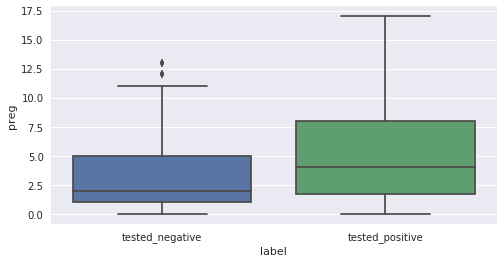

In [42]:
gSingleBoxplot(df_pimaCopy, "preg")

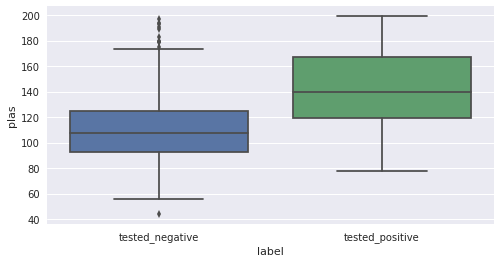

In [43]:
gSingleBoxplot(df_pimaCopy, "plas")

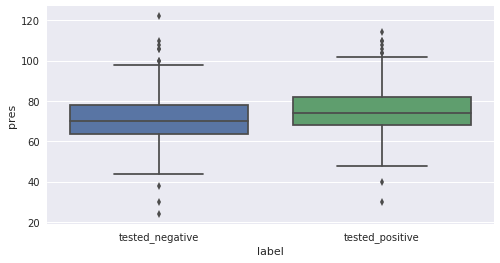

In [44]:
gSingleBoxplot(df_pimaCopy, "pres")

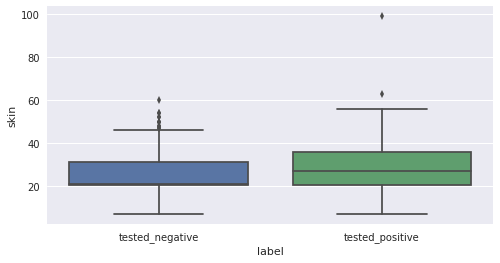

In [45]:
gSingleBoxplot(df_pimaCopy, "skin")

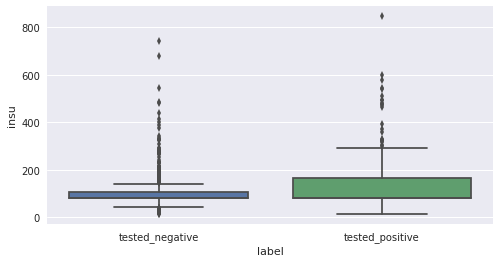

In [46]:
gSingleBoxplot(df_pimaCopy, "insu")

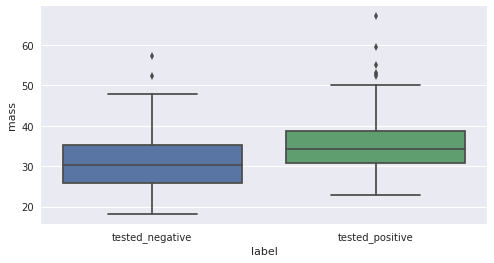

In [47]:
gSingleBoxplot(df_pimaCopy, "mass")

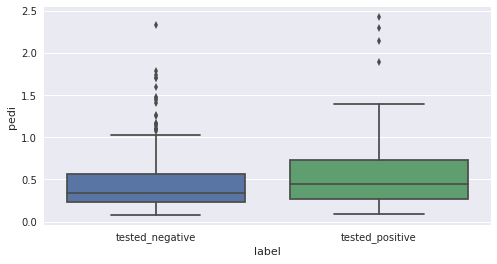

In [48]:
gSingleBoxplot(df_pimaCopy, "pedi")

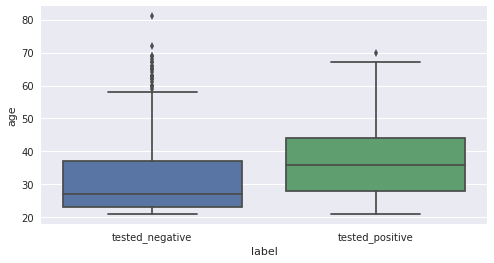

In [49]:
gSingleBoxplot(df_pimaCopy, "age")

Como podemos observar, se ve bastante bien que la variable más relevante es 'plas'.

## Aprendizaje y evaluación de un clasificador OneR

In [50]:
(TrainingPima,TestPima) = holdout_estratificado(0.6, df_pimaCopy, seed)

(tab, accuracy) = trainAndEvalClassifier(trainOneR, TrainingPima, TestPima, nbins=len(df_pimaCopy.label.unique()))
tab

-----------------------------------
Training OneR
-----------------------------------
attribute	error
preg 	 150
plas 	 125
pres 	 161
skin 	 160
insu 	 159
mass 	 152
pedi 	 157
age 	 161
-----------------------------------


prediction,tested_negative,tested_positive
label,,
tested_negative,160,41
tested_positive,38,69


In [51]:
accuracy

0.7435064935064936

In [52]:
TP = tab['tested_positive']['tested_positive']
FN = tab['tested_negative']['tested_positive']

recall(TP,FN)

0.64485981308411211

El accuracy mejora bastante, ya que al sustituir los valores "erróneos" por la media de la variable, esto nos hace generalizar más el proceso, por lo tanto mejora bastante a la hora de calcular el clasificador OneR.
En cuanto al recall, mejora con respecto a los anteriores pero aun el número mal clasificados son significativos.

## Aprendizaje y evaluación de un árbol de clasificación

In [53]:
(TrainingPima,TestPima) = holdout_estratificado(0.6, df_pimaCopy, seed)
(accuracy,prediction) = arbolDecision(TrainingPima,TestPima)
pd.crosstab(TestPima['label'], prediction)


col_0,tested_negative,tested_positive
label,,
tested_negative,146,55
tested_positive,47,60


In [54]:
accuracy

0.6688311688311688

In [55]:
TP = pd.crosstab(TestPima['label'], prediction)['tested_positive']['tested_positive']
FN = pd.crosstab(TestPima['label'], prediction)['tested_negative']['tested_positive']

recall(TP,FN)

0.56074766355140182

En este caso, a la hora de calcular el árbol de clasificación, aunque se podría pensar que mejora, empeora ya que realiza un sobreajuste, esto es debido a que hace un muy buen clasificador con el conjunto de datos de Training, y a la hora de tener datos nuevos del conjunto de Test, empeora.
En cuanto al recall es peor que el anterior.

# Wisconsin
A continuación, vamos a proceder a analizar el conjunto de datos de Wisconsin

In [56]:
# Cargamos el fichero con el conjunto de datos. OJO: colocar el fichero de datos en el mismo directorio que esta libreta

df_wisconsin = pd.read_csv("wisconsin.csv", dtype={ "label": 'category'})

In [57]:
# Vamos a conocer un poquito el dataset, para ello veamos el nº de instancias y el nº de variables a tratar

aux2 = df_wisconsin.shape
print("Nº de instancias: " + str(aux2[0]))
print("Nº de variables a tratar: " + str(aux2[1]-1))

df_wisconsin.describe()

Nº de instancias: 699
Nº de variables a tratar: 10


,patientId,clumpThickness,cellSize,CellShape,marginalAdhesion,epithelialSize,bareNuclei,blandChromatin,normalNucleoli,mitoses
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,667.000000,699.000000,699.000000,699.000000
mean,350.000000,4.417740,3.134478,3.207439,2.806867,3.216023,3.536732,3.437768,2.866953,1.589413
std,201.928205,2.815741,3.051459,2.971913,2.855379,2.214300,3.683795,2.438364,3.053634,1.715078
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,175.500000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,350.000000,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,524.500000,6.000000,5.000000,5.000000,4.000000,4.000000,7.000000,5.000000,4.000000,1.000000
max,699.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


## Visualización de las variables
Para ir analizando todos los datos del dataset vamos a realizar una serie de histogramas, diagramas de cajas (para las variables numéricas) y un diagrama de barras (para la variable clase discreta).

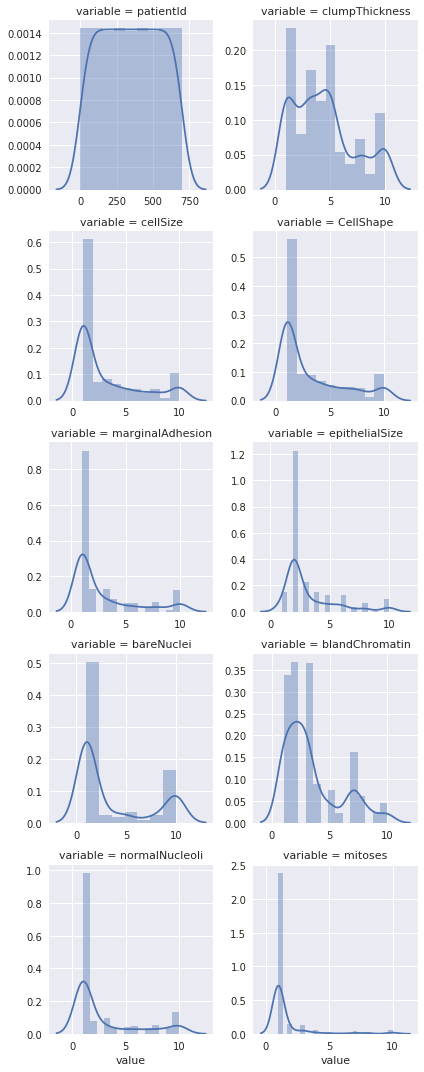

In [58]:
 gMultipleHistogram(df_wisconsin)

Variable clumpThickness, con valor == 1: 145
Variable cellSize, con valor == 1: 384
Variable CellShape, con valor == 1: 353
Variable marginalAdhesion, con valor == 1: 407
Variable epithelialSize, con valor == 1: 47
Variable bareNuclei, con valor == 1: 402
Variable blandChromatin, con valor == 1: 152
Variable normalNucleoli, con valor == 1: 443
Variable mitoses, con valor == 1: 579
Variable clase, con valor == benign: 458
Variable clase, con valor == malignant: 241


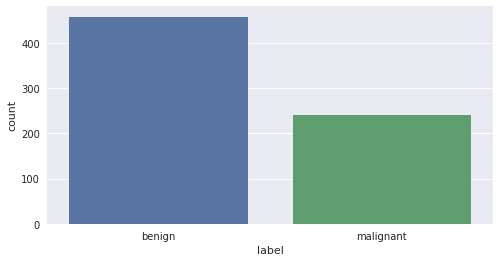

In [59]:
gSingleBarplot(df_wisconsin, "label")
print ("Variable clumpThickness, con valor == 1: " + str(df_wisconsin[df_wisconsin["clumpThickness"] == 1].shape[0]))
print ("Variable cellSize, con valor == 1: " + str(df_wisconsin[df_wisconsin["cellSize"] == 1].shape[0]))
print ("Variable CellShape, con valor == 1: " + str(df_wisconsin[df_wisconsin["CellShape"] == 1].shape[0]))
print ("Variable marginalAdhesion, con valor == 1: " + str(df_wisconsin[df_wisconsin["marginalAdhesion"] == 1].shape[0]))
print ("Variable epithelialSize, con valor == 1: " + str(df_wisconsin[df_wisconsin["epithelialSize"] == 1].shape[0]))
print ("Variable bareNuclei, con valor == 1: " + str(df_wisconsin[df_wisconsin["bareNuclei"] == 1].shape[0]))
print ("Variable blandChromatin, con valor == 1: " + str(df_wisconsin[df_wisconsin["blandChromatin"] == 1].shape[0]))
print ("Variable normalNucleoli, con valor == 1: " + str(df_wisconsin[df_wisconsin["normalNucleoli"] == 1].shape[0]))
print ("Variable mitoses, con valor == 1: " + str(df_wisconsin[df_wisconsin["mitoses"] == 1].shape[0]))

print ("Variable clase, con valor == benign: " + str(df_wisconsin[df_wisconsin["label"] == "benign"].shape[0]))
print ("Variable clase, con valor == malignant: " + str(df_wisconsin[df_wisconsin["label"] == "malignant"].shape[0]))

Información de los atributos:

1. 'patientId' -> Número de identificación
2. 'Clump thickness' -> Grosor del cuerpo
3. 'Cell size' -> Tamaño de celda
4. 'Cell shape' -> Forma de celda
5. 'Marginal adhesion' -> Adhesión marginal
6. 'Epithelial size' -> Tamaño epitelial
7. 'BareNuclei' -> Nucleos desnudos
8. 'Blandchromatin' -> Cromatina suave
9. 'NormalNucleoile' -> Nucleolos normales
10. 'Mitoses' -> Mitosis
11. Diagnóstico (M = maligno, B = benigno)


Para empezar, tras visualizar las variables a analizar, está claro que debemos de eliminar para la clasificación, la variable patientID, puesto que este no nos sirve para clasificar y se puede confundir a la hora de ejecutar el algoritmo OneR, ya que es la variable que mas discrimina (teniendo cada uno un ID diferente).

Las demás variables, ya que no somos expertos, no podemos saber si existen valores erróneos o perdidos, pero leyendo la especificación del dataset, nos indica que no existen valores perdidos.

Mirando detenidamente los histogramas, podemos comprobar que al menos 7 de las variables tienen un gran número de instancias con el valor mínimo de 1, y esto nos puede llevar a pensar que se trata de valores erróneos o perdidos, por esto vamos a analizar a continuación este dataset sin preprocesar los datos para posteriormente eliminar dichos 1s, para observar si la clasificación mejora.

Con los histogramas obtenidos, no somos capaces de determinar cuales son las variables con mayor relevancia, para ello, analizaremos los diagramas de cajas de cada una de ellas con respecto a la variable clase.

Por último, nos queda comentar que la muestra no está balanceada debido a que las frecuencias de las distintas combinaciones de estados de las mismas no aparecen en la misma proporción. 458 instancias de benignos con respecto a 241 de malignos.

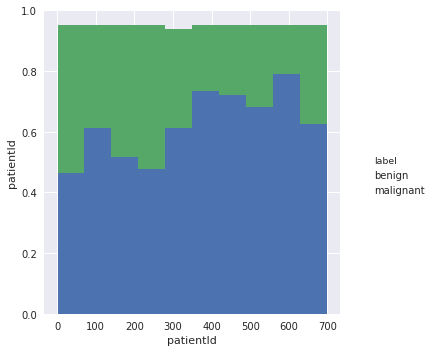

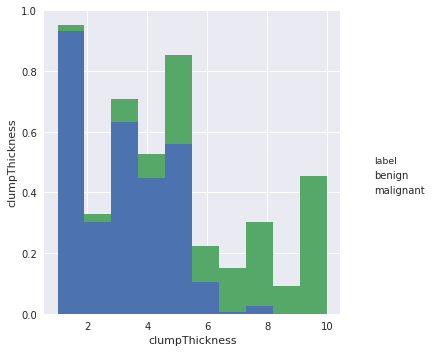

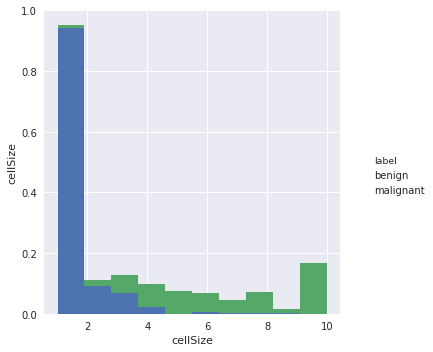

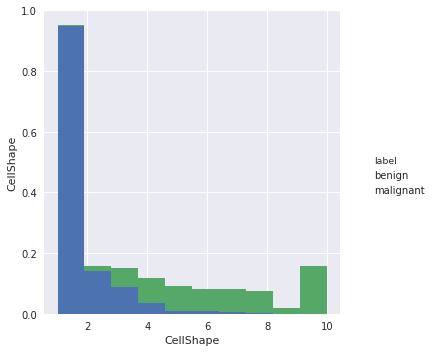

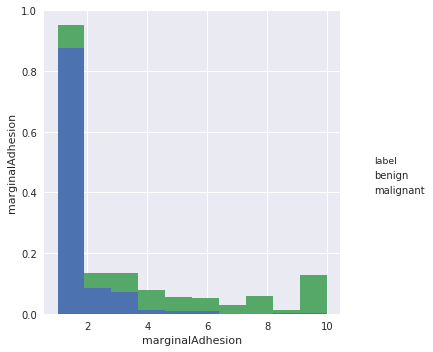

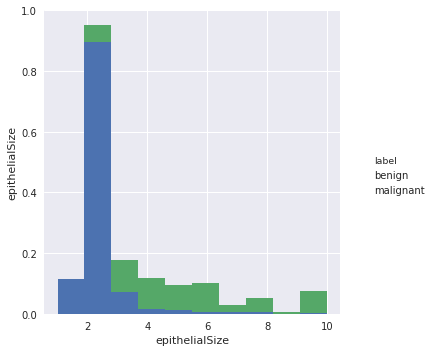

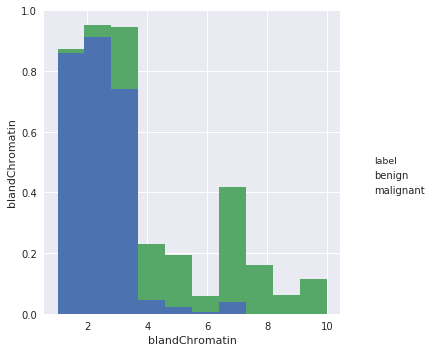

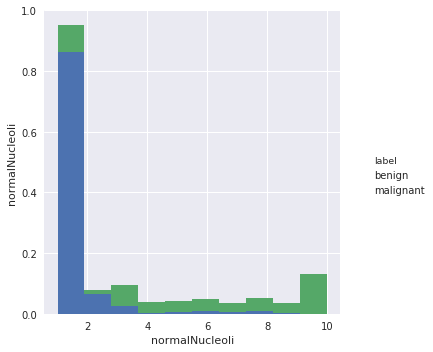

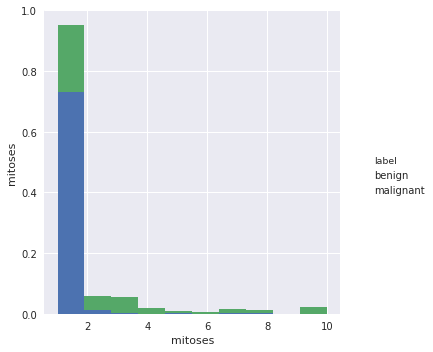

In [60]:
gSingleConditionalHistogram(df_wisconsin, "patientId")
gSingleConditionalHistogram(df_wisconsin, "clumpThickness")
gSingleConditionalHistogram(df_wisconsin, "cellSize")
gSingleConditionalHistogram(df_wisconsin, "CellShape")
gSingleConditionalHistogram(df_wisconsin, "marginalAdhesion")
gSingleConditionalHistogram(df_wisconsin, "epithelialSize")
#gSingleConditionalHistogram(df_wisconsin, "bareNuclei")
gSingleConditionalHistogram(df_wisconsin, "blandChromatin")
gSingleConditionalHistogram(df_wisconsin, "normalNucleoli")
gSingleConditionalHistogram(df_wisconsin, "mitoses")

Mirando los histogramas condicionales, podemos apreciar más o menos que las variables de mayor importancia son CellSize, CellShape, MarginalAdhesion, EpithelialSize, BlandChromatin, NormalNucleoli.

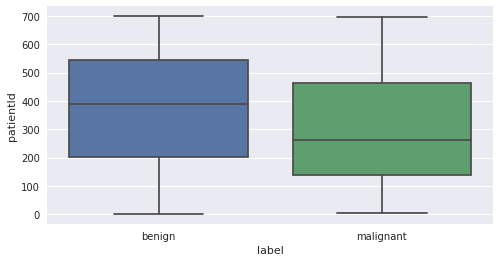

In [61]:
gSingleBoxplot(df_wisconsin, "patientId")

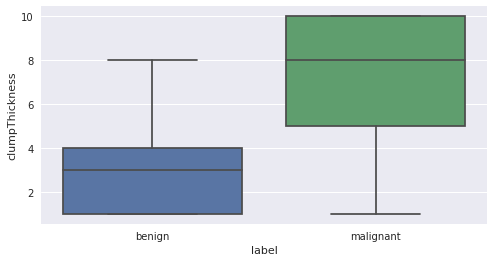

In [62]:
gSingleBoxplot(df_wisconsin, "clumpThickness")

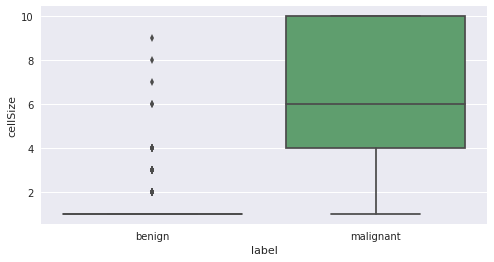

In [63]:
gSingleBoxplot(df_wisconsin, "cellSize")

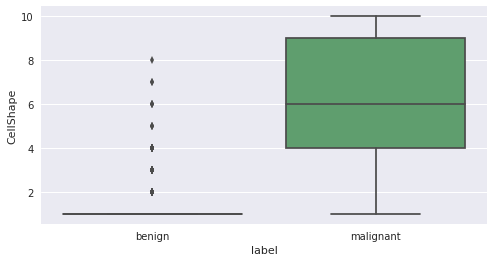

In [64]:
gSingleBoxplot(df_wisconsin, "CellShape")

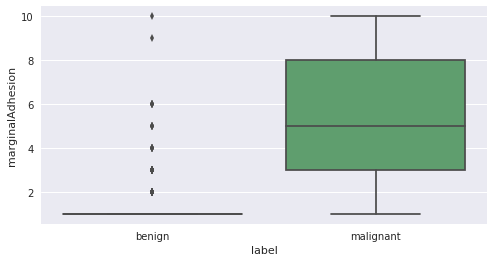

In [65]:
gSingleBoxplot(df_wisconsin, "marginalAdhesion")

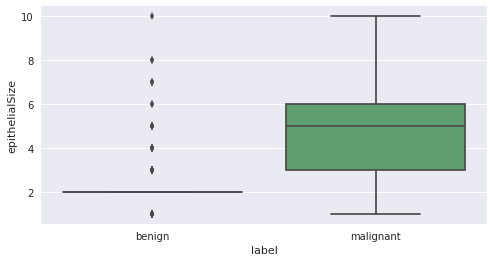

In [66]:
gSingleBoxplot(df_wisconsin, "epithelialSize")

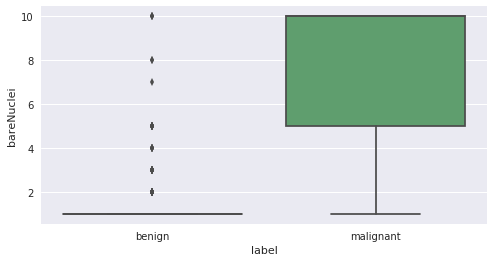

In [67]:
gSingleBoxplot(df_wisconsin, "bareNuclei")

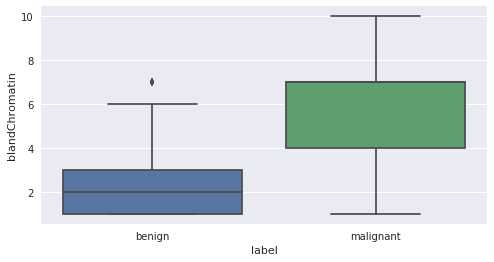

In [68]:
gSingleBoxplot(df_wisconsin, "blandChromatin")

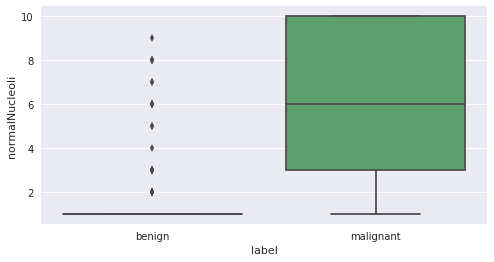

In [69]:
gSingleBoxplot(df_wisconsin, "normalNucleoli")

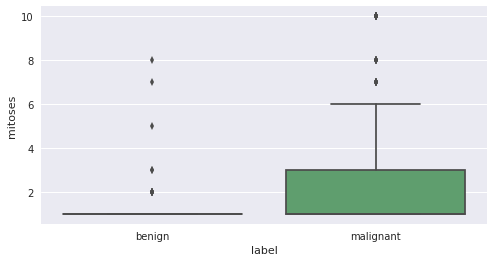

In [70]:
gSingleBoxplot(df_wisconsin, "mitoses")

Considerando los diagramas de cajas, podemos deducir que las variables más relevantes serán aquellas cuyas 'cajas' se superpongan menos, es decir, aquellas en las que los valores de la variable estén más diferenciadas dependiendo de la variable clase. Por lo tanto, concluimos que las variables 'clumpThickness' , 'blandChromatin' (mayor a menor relevancia). Se podría pensar, que el resto de variables podrían ser discriminatorias (a excepción de patientID), pero al ser la caja tan fina y habiendo tantos datos atípicos, no podemos asegurar que realmente discrimine como tal. 

Las variables nombradas es una aproximación a "ojo", el clasificador OneR ya nos proporcionará cuales son las mejores y actuará en consecuencia.

In [71]:
#gPairPlot(df_pima) - Test (10*10 = 100 tablas!!!!)

## Aprendizaje y evaluación de un clasificador ZeroR


In [72]:
(TrainingWisconsin,TestWisconsin) = holdout_estratificado(0.6, df_wisconsin, seed)
(tab, accuracy) = trainAndEvalClassifier(trainZeroR, TrainingWisconsin, TestWisconsin)
tab

prediction,benign
label,
benign,183
malignant,97


In [73]:
accuracy

0.6535714285714286

Como podemos apreciar, un ZeroR obtiene un mal accuracy puesto que clasificar todo como la variable mayoritaria es bastante ineficiente antes nuevos casos.
El clasificador ZeroR predice cualquier caso como 'benign'.
Si calculasemos el recall, sería de 0, dado que clasificamos todos como benignos.

## Aprendizaje y evaluación de un clasificador OneR
Para realizar la clasificación OneR, vamos a trabajar con aquellas variables que hemos indicado que son las más relevantes ('plas' , 'preg', 'age' y 'mass')

In [74]:
(TrainingWisconsin,TestWisconsin) = holdout_estratificado(0.6, df_wisconsin, seed)
(tab, accuracy) = trainAndEvalClassifier(trainOneR, TrainingWisconsin, TestWisconsin, nbins=len(df_wisconsin.label.unique()))
tab

-----------------------------------
Training OneR
-----------------------------------
attribute	error
patientId 	 144
clumpThickness 	 58
cellSize 	 60
CellShape 	 59
marginalAdhesion 	 73
epithelialSize 	 83
bareNuclei 	 38
blandChromatin 	 68
normalNucleoli 	 72
mitoses 	 122
-----------------------------------


prediction,benign,malignant
label,,
benign,171,4
malignant,25,66


In [75]:
accuracy

0.8464285714285714

In [76]:
TP = tab['malignant']['malignant']
FN = tab['benign']['malignant']

recall(TP,FN)

0.72527472527472525

Tras el procesamiento, OneR elige la variable 'bareNuclei' como la mejor variable para clasificar, debido a que tiene el menor error.
El accuracy es bueno, esto significa que hemos obtenido un buen modelo que generaliza bien. En cuanto al recall, es bastante bueno pero, más o menos, uno de cada cuatro casos en los que el tumor el maligno se clasifica como benigno. Dado que en estos casos se trata un tema de salud, se debe intentar conseguir un mayor recall.

## Aprendizaje y evaluación de un árbol de clasificación

In [77]:
#(TrainingWisconsin,TestWisconsin) = holdout_estratificado(0.6, df_wisconsin, seed)
#(accuracy,prediction) = arbolDecision(TrainingWisconsin,TestWisconsin)
#pd.crosstab(TestWisconsin['label'], prediction)
#accuracy

No podemos ejecutarlo debido a la presencia de NaN's en la base de datos wisconsin.

## Preprocesamiento de datos de df_wisconsin (Sustitución de 1's por NaN)

Hemos comprobrado que en esta base de datos ya se encuentran los datos preprocesados, habiendo NaN's, por lo tanto con todo lo analizado anteriormente, posiblemente si tratamos los datos que hemos mencionado antes, podríamos llegar a conseguir unos mejores clasificadores, para ello, vamos a eliminar los 1s de las variables 'cellSize', 'cellShape', 'marginalAdhesion', 'bareNuclei', 'normalNucleoli', 'mitoses' (elegimos estas variables y todas puesto que éstas son las que más número de 1's presenta), por ello vamos a sustituir estos valores por NaN, estos cambios deberían ser contrastados por un experto pero dado que carecemos de ello, vamos a suponerlo.
Haremos una copia de df_wisconsin y trataremos los datos.

In [78]:
df_wisconsinCopy = df_wisconsin.copy()
df_wisconsinCopy["cellSize"].replace(1, np.nan, inplace=True)
df_wisconsinCopy["CellShape"].replace(1, np.nan, inplace=True)
df_wisconsinCopy["marginalAdhesion"].replace(1, np.nan, inplace=True)
df_wisconsinCopy["bareNuclei"].replace(1, np.nan, inplace=True)
df_wisconsinCopy["normalNucleoli"].replace(1, np.nan, inplace=True)
df_wisconsinCopy["mitoses"].replace(1, np.nan, inplace=True)
df_wisconsinCopy.describe()

,patientId,clumpThickness,cellSize,CellShape,marginalAdhesion,epithelialSize,bareNuclei,blandChromatin,normalNucleoli,mitoses
count,699.000000,699.000000,315.000000,346.000000,292.000000,699.000000,265.000000,699.000000,256.000000,120.000000
mean,350.000000,4.417740,5.736508,5.459538,5.325342,3.216023,7.384906,3.437768,6.097656,4.433333
std,201.928205,2.815741,2.887007,2.792295,2.936962,2.214300,3.093701,2.438364,2.998404,2.721632
min,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000
25%,175.500000,2.000000,3.000000,3.000000,3.000000,2.000000,5.000000,2.000000,3.000000,2.000000
50%,350.000000,4.000000,5.000000,5.000000,4.000000,2.000000,9.000000,3.000000,6.000000,3.000000
75%,524.500000,6.000000,8.000000,8.000000,8.000000,4.000000,10.000000,5.000000,9.000000,7.000000
max,699.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [79]:
#df_wisconsinCopy #- Test: comprobacion de si se han remplazado los valores

Como podemos observar, al sustituir estos valores por NaN "perdemos" registros, y esto puede suponer un problema a la hora de calcular los clasificadores.

Dado que los histogramas no nos han aportado apenas información, vamos a realizar una serie de diagramas de cajas para cada una de las variables con respecto a la variable clase, para comprobar que variables son las más relevantes.

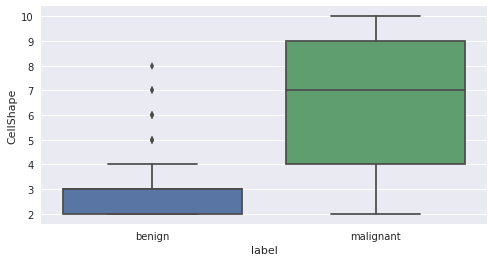

In [80]:
gSingleBoxplot(df_wisconsinCopy, "CellShape")

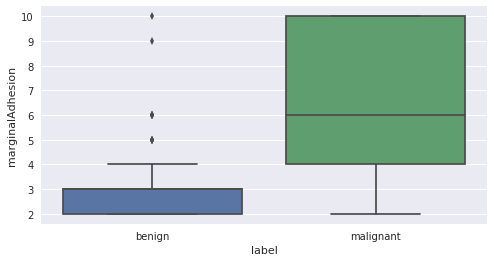

In [81]:
gSingleBoxplot(df_wisconsinCopy, "marginalAdhesion")

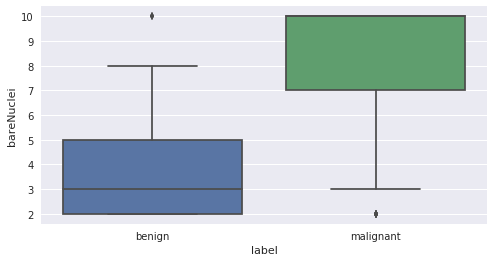

In [82]:
gSingleBoxplot(df_wisconsinCopy, "bareNuclei")

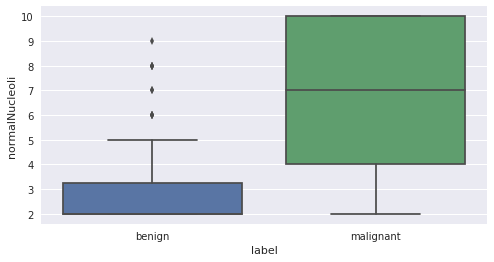

In [83]:
gSingleBoxplot(df_wisconsinCopy, "normalNucleoli")

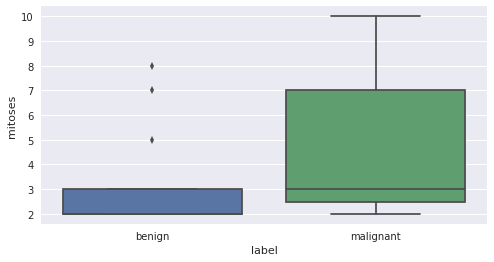

In [84]:
gSingleBoxplot(df_wisconsinCopy, "mitoses")

Podemos observar que los diagramas de cajas han variado bastante con respecto al principio, y podemos comprobar de mejor manera cuales son las variables más relevantes. Para nosotros las más relevante es 'bareNuclei', dado que es el que se encuentra menos solapado.

Tiene su lógica de que bareNuclei sea la variable con mayor relevancia, dado que en el OneR ejecutado sin preprocesar los datos, esta era la que tenía menor error.

A continuación, vamos a hacer una clasificación con OneR y árboles de clasificación, en el caso del algoritmo ZeroR, no vamos a calcularlo, ya que no variará, por que solo se fija en la variable clase.

## Aprendizaje y evaluación de un clasificador OneR

In [85]:
(TrainingWisconsin,TestWisconsin) = holdout_estratificado(0.6, df_wisconsinCopy, seed)
(tab, accuracy) = trainAndEvalClassifier(trainOneR, TrainingWisconsin, TestWisconsin, nbins=len(df_wisconsinCopy.label.unique()))
tab

-----------------------------------
Training OneR
-----------------------------------
attribute	error
patientId 	 144
clumpThickness 	 58
cellSize 	 49
CellShape 	 68
marginalAdhesion 	 50
epithelialSize 	 83
bareNuclei 	 22
blandChromatin 	 68
normalNucleoli 	 32
mitoses 	 8
-----------------------------------


prediction,malignant
label,
benign,5
malignant,39


In [86]:
accuracy

0.1392857142857143

In [87]:
TP = tab['malignant']['malignant']
FN = 0

recall(TP,FN)

1.0

In [88]:
TrainingWisconsin.describe()

,patientId,clumpThickness,cellSize,CellShape,marginalAdhesion,epithelialSize,bareNuclei,blandChromatin,normalNucleoli,mitoses
count,419.000000,419.000000,191.000000,213.000000,174.000000,419.000000,147.00000,419.000000,155.000000,76.000000
mean,356.463007,4.357995,5.748691,5.436620,5.505747,3.241050,7.70068,3.443914,6.290323,4.434211
std,201.723816,2.858003,2.900034,2.837081,3.012013,2.205178,2.89642,2.419731,2.976025,2.801597
min,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.00000,1.000000,2.000000,2.000000
25%,183.500000,2.000000,3.000000,3.000000,3.000000,2.000000,5.00000,2.000000,3.500000,2.000000
50%,357.000000,4.000000,5.000000,5.000000,4.500000,2.000000,10.00000,3.000000,6.000000,3.000000
75%,532.500000,6.000000,8.000000,8.000000,8.000000,4.000000,10.00000,5.000000,10.000000,6.250000
max,697.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000


In [89]:
TestWisconsin.describe()

,patientId,clumpThickness,cellSize,CellShape,marginalAdhesion,epithelialSize,bareNuclei,blandChromatin,normalNucleoli,mitoses
count,280.000000,280.000000,124.000000,133.000000,118.000000,280.000000,118.000000,280.000000,101.000000,44.000000
mean,340.328571,4.507143,5.717742,5.496241,5.059322,3.178571,6.991525,3.428571,5.801980,4.431818
std,202.208184,2.753939,2.878461,2.729258,2.814166,2.231311,3.293339,2.470305,3.023309,2.609444
min,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000
25%,160.500000,2.000000,3.000000,3.000000,3.000000,2.000000,3.250000,2.000000,3.000000,2.000000
50%,333.500000,4.000000,5.000000,5.000000,4.000000,2.000000,8.500000,3.000000,6.000000,3.000000
75%,515.750000,6.000000,8.000000,8.000000,7.000000,4.000000,10.000000,4.250000,8.000000,7.000000
max,699.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


Como podemos comprobar, OneR elige la variable 'mitoses' como clasificador, por lo tanto creará una regla y evaluará todos los casos conforme a esta variable. Además, los registros cuyas variables hemos sustituido por NaN se pierden, por lo tanto no se usan a la hora del entrenamiento, por ello baja tanto el accuracy.
Como podemos observar, obtenemos un recall es de 1 ya que clasificamos todos los casos como malignos, esto es debido a que preprocesamos los datos, cambiando todos los 1's por NaN's y nos quedamos sin casos de beningnos, ya que todos ellos disponen de algún NaN y se pierden.

## Aprendizaje y evaluación de un árbol de clasificación

In [90]:
# NO SE PUEDE EJECUTAR: los valores NaN no permiten la construcción del árbol.
#(TrainingPima,TestPima) = holdout_estratificado(0.6, df_pimaCopy, seed)
#(accuracy,prediction) = arbolDecision(TrainingPima,TestPima)
#pd.crosstab(TestPima['label'], prediction)
#accuracy

## Preprocesamiento de datos de df_wisconsin (Sustitución de 1's por la media)
Con todo lo analizado anteriormente, en este caso vamos a sustituir los 0s de las variables 'cellSize', 'CellShape', 'marginalAdhesion', 'bareNuclei', 'normalNucleoli' y 'mitoses' (elegimos estas variables y todas puesto que éstas son las que más número de 1's presenta) por la media.
Haremos una copia de df_wisconsin y trataremos los datos.

In [91]:
df_wisconsinCopy = df_wisconsin.copy()
df_wisconsinCopy["cellSize"].replace(1, df_wisconsin["cellSize"].mean(), inplace=True)
df_wisconsinCopy["CellShape"].replace(1, df_wisconsin["CellShape"].mean(), inplace=True)
df_wisconsinCopy["marginalAdhesion"].replace(1, df_wisconsin["marginalAdhesion"].mean(), inplace=True)
df_wisconsinCopy["bareNuclei"].replace(1, df_wisconsin["bareNuclei"].mean(), inplace=True)
df_wisconsinCopy["normalNucleoli"].replace(1, df_wisconsin["normalNucleoli"].mean(), inplace=True)
df_wisconsinCopy["mitoses"].replace(1, df_wisconsin["mitoses"].mean(), inplace=True)
df_wisconsinCopy.describe()

,patientId,clumpThickness,cellSize,CellShape,marginalAdhesion,epithelialSize,bareNuclei,blandChromatin,normalNucleoli,mitoses
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,667.000000,699.000000,699.000000,699.000000
mean,350.000000,4.417740,4.307067,4.322212,3.858934,3.216023,5.065616,3.437768,4.050157,2.077640
std,201.928205,2.815741,2.329811,2.263504,2.267397,2.214300,2.710194,2.438364,2.389675,1.553900
min,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.589413
25%,175.500000,2.000000,3.134478,3.207439,2.806867,2.000000,3.536732,2.000000,2.866953,1.589413
50%,350.000000,4.000000,3.134478,3.207439,2.806867,2.000000,3.536732,3.000000,2.866953,1.589413
75%,524.500000,6.000000,5.000000,5.000000,4.000000,4.000000,7.000000,5.000000,4.000000,1.589413
max,699.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [92]:
#df_pimaCopy - Test: comprobacion de si se han remplazado los valores

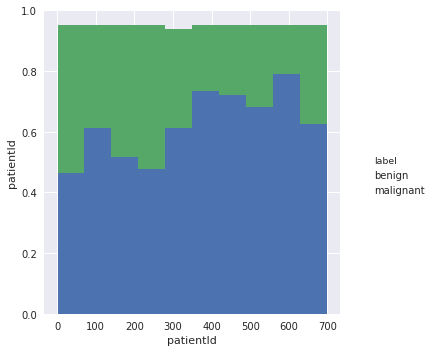

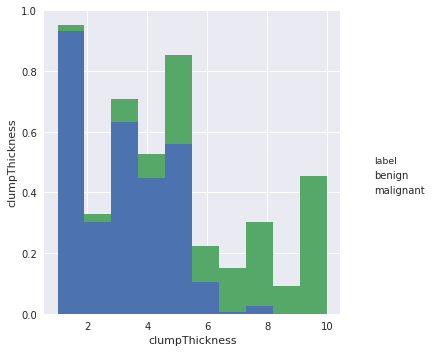

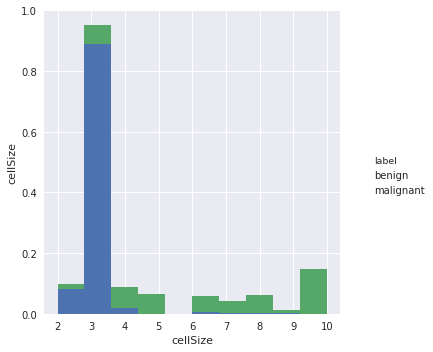

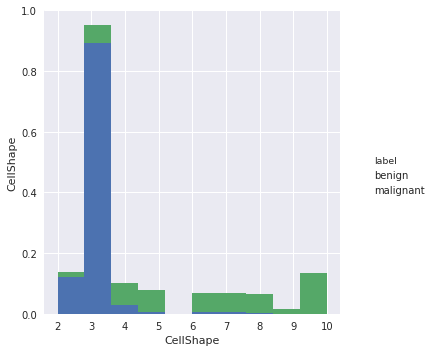

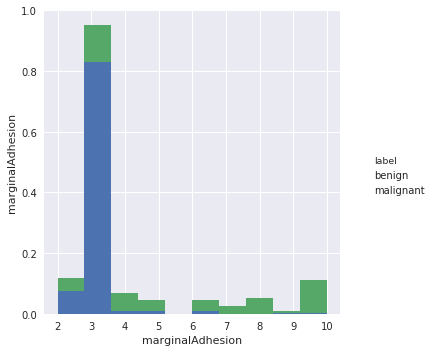

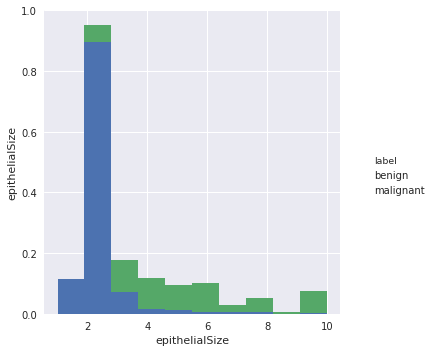

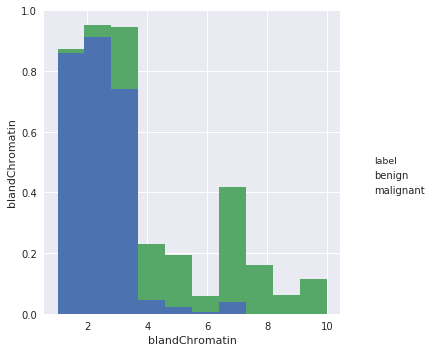

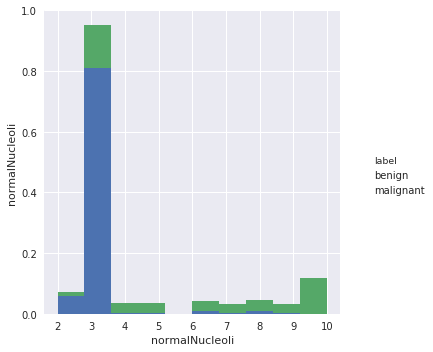

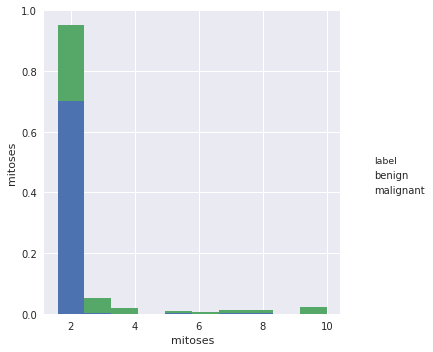

In [93]:
gSingleConditionalHistogram(df_wisconsinCopy, "patientId")
gSingleConditionalHistogram(df_wisconsinCopy, "clumpThickness")
gSingleConditionalHistogram(df_wisconsinCopy, "cellSize")
gSingleConditionalHistogram(df_wisconsinCopy, "CellShape")
gSingleConditionalHistogram(df_wisconsinCopy, "marginalAdhesion")
gSingleConditionalHistogram(df_wisconsinCopy, "epithelialSize")
#gSingleConditionalHistogram(df_wisconsinCopy, "bareNuclei")
gSingleConditionalHistogram(df_wisconsinCopy, "blandChromatin")
gSingleConditionalHistogram(df_wisconsinCopy, "normalNucleoli")
gSingleConditionalHistogram(df_wisconsinCopy, "mitoses")

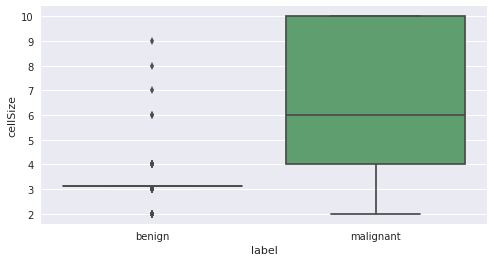

In [94]:
gSingleBoxplot(df_wisconsinCopy, "cellSize")

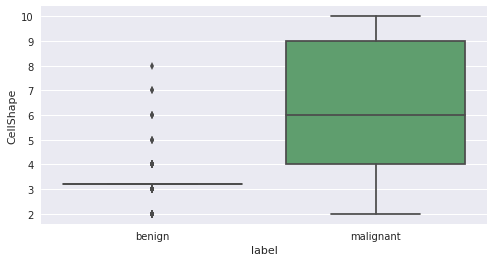

In [95]:
gSingleBoxplot(df_wisconsinCopy, "CellShape")

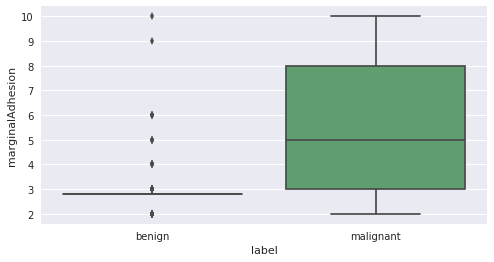

In [96]:
gSingleBoxplot(df_wisconsinCopy, "marginalAdhesion")

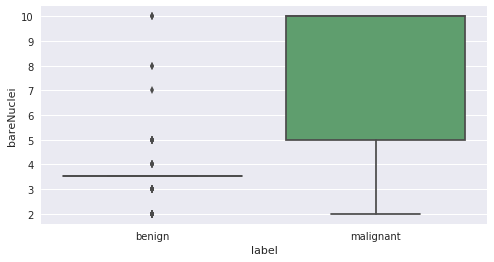

In [97]:
gSingleBoxplot(df_wisconsinCopy, "bareNuclei")

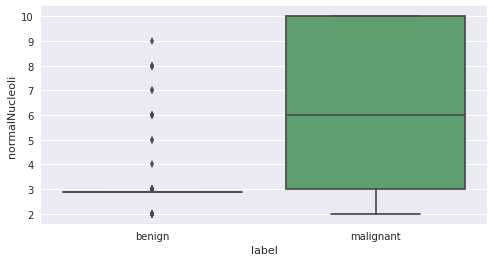

In [98]:
gSingleBoxplot(df_wisconsinCopy, "normalNucleoli")

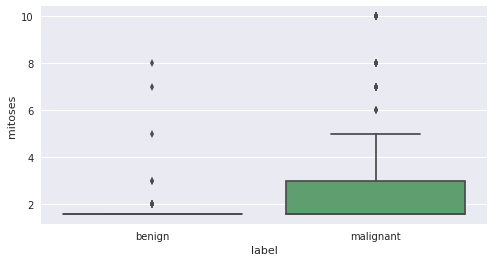

In [99]:
gSingleBoxplot(df_wisconsinCopy, "mitoses")

En este caso, este preprocesamiento no mejora la visibilidad de la importancia de las variables mediante los diagramas de cajas. Pero haciendo uso de los histogramas condicionales, podríamos decir que las variables que mejor clasificarán serán: 'cellSize', 'CellShape', 'epithelialSize' y 'blandChromatin'.

## Aprendizaje y evaluación de un clasificador OneR

In [100]:
(TrainingWisconsin,TestWisconsin) = holdout_estratificado(0.6, df_wisconsinCopy, seed)

(tab, accuracy) = trainAndEvalClassifier(trainOneR, TrainingWisconsin, TestWisconsin, nbins=len(df_wisconsinCopy.label.unique()))
tab

-----------------------------------
Training OneR
-----------------------------------
attribute	error
patientId 	 144
clumpThickness 	 58
cellSize 	 72
CellShape 	 69
marginalAdhesion 	 81
epithelialSize 	 83
bareNuclei 	 39
blandChromatin 	 68
normalNucleoli 	 84
mitoses 	 122
-----------------------------------


prediction,benign,malignant
label,,
benign,171,4
malignant,27,64


In [101]:
accuracy

0.8392857142857143

In [102]:
TP = tab['malignant']['malignant']
FN = tab['benign']['malignant']

recall(TP,FN)

0.70329670329670335

El accuracy baja un poquito con respecto al original sin procesar, ya que al sustituir los valores que consideramos "erróneos" por la media de la variable, esto nos hace generalizar más el proceso, por lo tanto puede ser una mejora a la hora de calcular el clasificador OneR, ya que sale más sencillo.
En cuanto al recall es aceptable pero sería preferible uno mayor.

## Aprendizaje y evaluación de un árbol de clasificación

In [103]:
#(TrainingWisconsin,TestWisconsin) = holdout_estratificado(0.6, df_wisconsinCopy, seed)
#(accuracy,prediction) = arbolDecision(TrainingWisconsin,TestWisconsin)
#pd.crosstab(TestWisconsin['label'], prediction)
#accuracy

No se puede ejecutar debido a la existencia de valores con NaN.

## Preprocesamiento de datos de df_wisconsin (Sustitución de NaN's por la media)
Con todo lo analizado anteriormente, en este caso vamos a sustituir los NaN's de las variables por la media.
Haremos una copia de df_wisconsin y trataremos los datos.

In [104]:
df_wisconsinCopy = df_wisconsin.copy()
df_wisconsinCopy["cellSize"].replace(np.nan, df_wisconsin["cellSize"].mean(), inplace=True)
df_wisconsinCopy["clumpThickness"].replace(np.nan, df_wisconsin["clumpThickness"].mean(), inplace=True)
df_wisconsinCopy["blandChromatin"].replace(np.nan, df_wisconsin["blandChromatin"].mean(), inplace=True)
df_wisconsinCopy["epithelialSize"].replace(np.nan, df_wisconsin["epithelialSize"].mean(), inplace=True)
df_wisconsinCopy["CellShape"].replace(np.nan, df_wisconsin["CellShape"].mean(), inplace=True)
df_wisconsinCopy["marginalAdhesion"].replace(np.nan, df_wisconsin["marginalAdhesion"].mean(), inplace=True)
df_wisconsinCopy["bareNuclei"].replace(np.nan, df_wisconsin["bareNuclei"].mean(), inplace=True)
df_wisconsinCopy["normalNucleoli"].replace(np.nan, df_wisconsin["normalNucleoli"].mean(), inplace=True)
df_wisconsinCopy["mitoses"].replace(np.nan, df_wisconsin["mitoses"].mean(), inplace=True)
df_wisconsinCopy.describe()



,patientId,clumpThickness,cellSize,CellShape,marginalAdhesion,epithelialSize,bareNuclei,blandChromatin,normalNucleoli,mitoses
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,350.000000,4.417740,3.134478,3.207439,2.806867,3.216023,3.536732,3.437768,2.866953,1.589413
std,201.928205,2.815741,3.051459,2.971913,2.855379,2.214300,3.598362,2.438364,3.053634,1.715078
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,175.500000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,350.000000,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,524.500000,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000
max,699.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [105]:
#df_wisconsinCopy - Test: comprobacion de si se han remplazado los valores

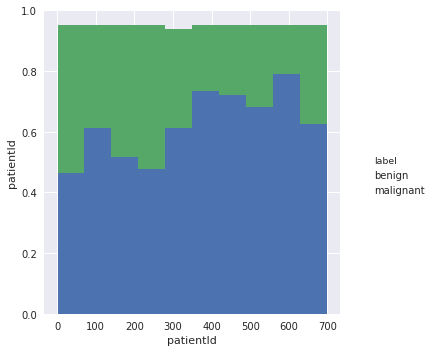

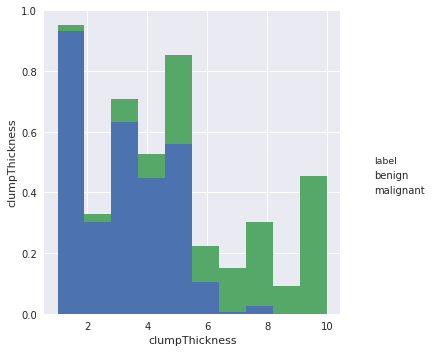

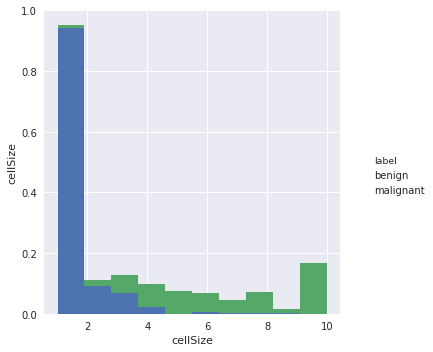

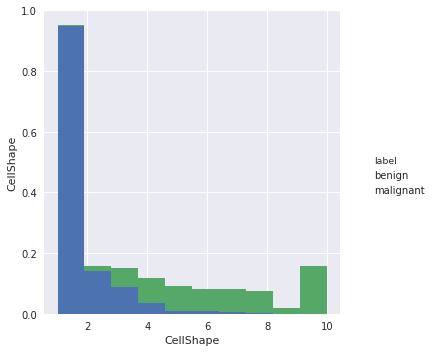

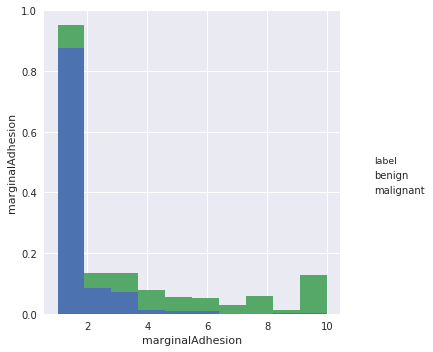

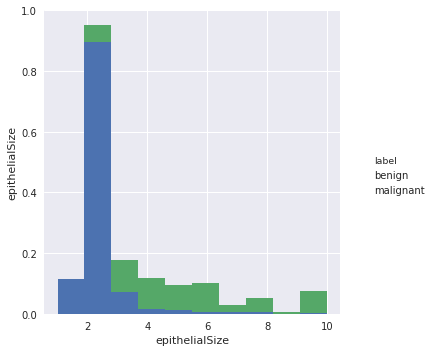

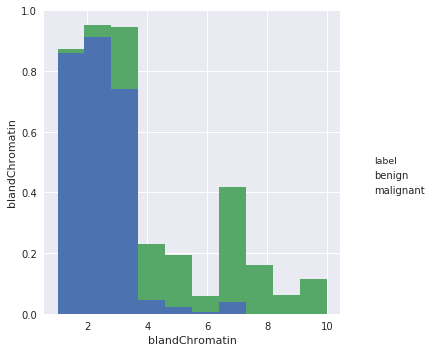

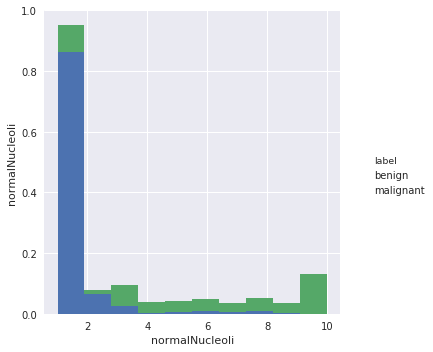

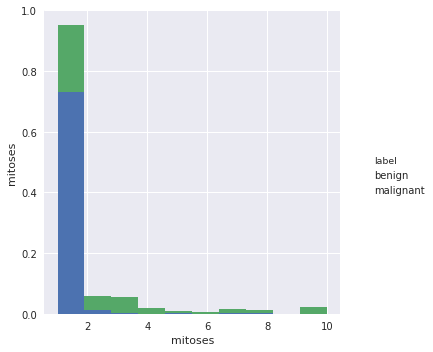

In [106]:
gSingleConditionalHistogram(df_wisconsinCopy, "patientId")
gSingleConditionalHistogram(df_wisconsinCopy, "clumpThickness")
gSingleConditionalHistogram(df_wisconsinCopy, "cellSize")
gSingleConditionalHistogram(df_wisconsinCopy, "CellShape")
gSingleConditionalHistogram(df_wisconsinCopy, "marginalAdhesion")
gSingleConditionalHistogram(df_wisconsinCopy, "epithelialSize")
#gSingleConditionalHistogram(df_wisconsinCopy, "bareNuclei")
gSingleConditionalHistogram(df_wisconsinCopy, "blandChromatin")
gSingleConditionalHistogram(df_wisconsinCopy, "normalNucleoli")
gSingleConditionalHistogram(df_wisconsinCopy, "mitoses")

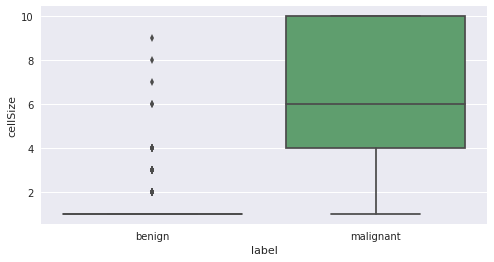

In [107]:
gSingleBoxplot(df_wisconsinCopy, "cellSize")

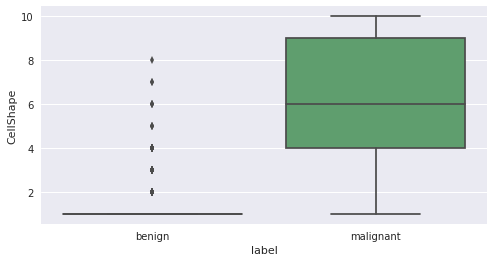

In [108]:
gSingleBoxplot(df_wisconsinCopy, "CellShape")

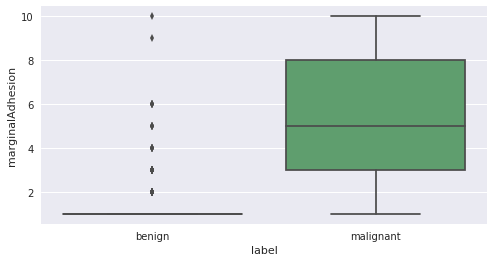

In [109]:
gSingleBoxplot(df_wisconsinCopy, "marginalAdhesion")

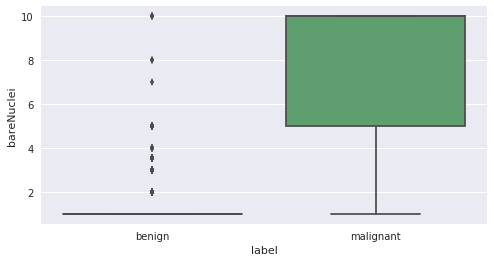

In [110]:
gSingleBoxplot(df_wisconsinCopy, "bareNuclei")

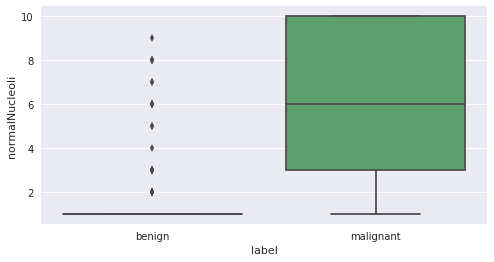

In [111]:
gSingleBoxplot(df_wisconsinCopy, "normalNucleoli")

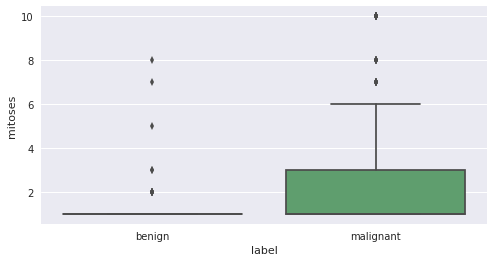

In [112]:
gSingleBoxplot(df_wisconsinCopy, "mitoses")

En este caso, este preprocesamiento no mejora la visibilidad de la importancia de las variables mediante los diagramas de cajas. Pero haciendo uso de los histogramas condicionales podríamos decir que las variables que mejor clasificarán son: 'cellSize', 'CellShape', 'marginalAdhesion', 'epithelialSize', 'blandChromatin' y 'normalNucleoli'.

## Aprendizaje y evaluación de un clasificador OneR

In [113]:
(TrainingWisconsin,TestWisconsin) = holdout_estratificado(0.6, df_wisconsinCopy, seed)

(tab, accuracy) = trainAndEvalClassifier(trainOneR, TrainingWisconsin, TestWisconsin, nbins=len(df_wisconsinCopy.label.unique()))
tab

-----------------------------------
Training OneR
-----------------------------------
attribute	error
patientId 	 144
clumpThickness 	 58
cellSize 	 60
CellShape 	 59
marginalAdhesion 	 73
epithelialSize 	 83
bareNuclei 	 45
blandChromatin 	 68
normalNucleoli 	 72
mitoses 	 122
-----------------------------------


prediction,benign,malignant
label,,
benign,179,4
malignant,31,66


In [114]:
accuracy

0.875

In [115]:
TP = tab['malignant']['malignant']
FN = tab['benign']['malignant']

recall(TP,FN)

0.68041237113402064

El accuracy sube un poquito, ya que al sustituir los valores que consideramos "erróneos" por la media de la variable, esto nos hace generalizar más el proceso, por lo tanto puede ser una mejora a la hora de calcular el clasificador OneR, ya que sale más sencillo.
En cuanto al recall es peor que los casos que hemos visto, por lo tanto descartamos este clasificador.

## Aprendizaje y evaluación de un árbol de clasificación

In [116]:
(TrainingWisconsin,TestWisconsin) = holdout_estratificado(0.6, df_wisconsinCopy, seed)
(accuracy,prediction) = arbolDecision(TrainingWisconsin,TestWisconsin)
pd.crosstab(TestWisconsin['label'], prediction)


col_0,benign,malignant
label,,
benign,175,8
malignant,11,86


In [117]:
accuracy

0.9321428571428572

In [118]:
TP = pd.crosstab(TestWisconsin['label'], prediction)['malignant']['malignant']
FN = pd.crosstab(TestWisconsin['label'], prediction)['benign']['malignant']

recall(TP,FN)

0.88659793814432986

En este último caso, obtenemos un buen accuracy y un buen recall. Por lo tanto hemos comprobado que sustituyendo los valores NaN del dataset por la media nos ha permitido realizar un arbol de clasificación que realiza una buena generalización de los datos y se obtiene un recall bastante aceptable, aunque siempre es preferible que sea todavía mayor. 

# Conclusiones
Hemos podido comprobar que realizando un preprocesamiento de los datos, en algunas ocasiones mejoramos en gran medida los modelos obtenidos por los clasificadores. También, dado que estamos trabajando con diagnosticos médicos y están en juego vidas humanas, es preferible diagnosticar una enfermedad aunque no se tenga (mejor prevenir que curar), por eso le hemos dado mayor importancia al recall con respecto al accuracy.
Debemos de resaltar la importancia de realizar holdout estratificado con el fin de dividir el dataset y usar una, y solo una vez, el conjunto de test.
Por último comentar que realizar un análisis de las gráficas "a ojo" es complicado, y siempre es preferible realizar un preprocesamiento de los datos para facilitar el entendimiento de las gráficas obtenidas.